In [1]:
import re
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plot

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV



we drop the TARGET_AMT column because we want to predict the TARGET_FLAG. So training a model with the TARGET_AMT amount as input is useless.   

In [2]:
train_data = pd.read_csv("data/auto-insurance-fall-2017/train_auto.csv")
train_data = train_data.drop(["INDEX","TARGET_AMT"],axis =1)

unlabeled_data = pd.read_csv("data/auto-insurance-fall-2017/test_auto.csv")
unlabeled_data = unlabeled_data.drop(["INDEX","TARGET_AMT"],axis =1)

In [3]:
train_data.columns

Index(['TARGET_FLAG', 'KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME',
       'PARENT1', 'HOME_VAL', 'MSTATUS', 'SEX', 'EDUCATION', 'JOB', 'TRAVTIME',
       'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR', 'OLDCLAIM',
       'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CAR_AGE', 'URBANICITY'],
      dtype='object')

In [4]:
# quick look on the data
train_data.head()

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


In [5]:
# quick look on the data
train_data.dtypes

TARGET_FLAG      int64
KIDSDRIV         int64
AGE            float64
HOMEKIDS         int64
YOJ            float64
INCOME          object
PARENT1         object
HOME_VAL        object
MSTATUS         object
SEX             object
EDUCATION       object
JOB             object
TRAVTIME         int64
CAR_USE         object
BLUEBOOK        object
TIF              int64
CAR_TYPE        object
RED_CAR         object
OLDCLAIM        object
CLM_FREQ         int64
REVOKED         object
MVR_PTS          int64
CAR_AGE        float64
URBANICITY      object
dtype: object

# Data preparation and analysis. 

## Nan values inputation

In [632]:
print(train_data.shape,unlabeled_data.shape)

(8161, 24) (2141, 24)


In [633]:
train_data.isna().sum()/train_data.shape[0]

TARGET_FLAG    0.000000
KIDSDRIV       0.000000
AGE            0.000735
HOMEKIDS       0.000000
YOJ            0.055630
INCOME         0.054528
PARENT1        0.000000
HOME_VAL       0.056856
MSTATUS        0.000000
SEX            0.000000
EDUCATION      0.000000
JOB            0.064453
TRAVTIME       0.000000
CAR_USE        0.000000
BLUEBOOK       0.000000
TIF            0.000000
CAR_TYPE       0.000000
RED_CAR        0.000000
OLDCLAIM       0.000000
CLM_FREQ       0.000000
REVOKED        0.000000
MVR_PTS        0.000000
CAR_AGE        0.062492
URBANICITY     0.000000
dtype: float64

In [634]:
train_data.dropna().shape

(6045, 24)

We have to much nan we can not drop them all. We need to find a solution to input them 
- I have decided to use the mean value to input Nan.

In [635]:
# for currency values we remove "$" and ","
for data in [train_data,unlabeled_data]:
    for col in ["HOME_VAL","INCOME", "OLDCLAIM","BLUEBOOK"]:
        data[col] = data[col].str.replace('$', '',regex=True).replace(",",'')
        data[col] = data[col].str.replace(",",'')
        data[col] = data[col].astype(float)

    data.YOJ = data.YOJ.fillna(train_data.YOJ.mean())
    data.INCOME = data.INCOME.fillna(train_data.INCOME.mean())
    data.HOME_VAL = data.HOME_VAL.fillna(train_data.HOME_VAL.mean())
    data.AGE = data.AGE.fillna(train_data.AGE.mean())
    data.CAR_AGE = data.CAR_AGE.fillna(train_data.CAR_AGE.mean())

    # for unknown job I will create another category "Unknown"
    data.JOB = data.JOB.fillna("UNKNOW")
   

In [636]:
unlabeled_data.isna().sum()/unlabeled_data.shape[0]

TARGET_FLAG    1.0
KIDSDRIV       0.0
AGE            0.0
HOMEKIDS       0.0
YOJ            0.0
INCOME         0.0
PARENT1        0.0
HOME_VAL       0.0
MSTATUS        0.0
SEX            0.0
EDUCATION      0.0
JOB            0.0
TRAVTIME       0.0
CAR_USE        0.0
BLUEBOOK       0.0
TIF            0.0
CAR_TYPE       0.0
RED_CAR        0.0
OLDCLAIM       0.0
CLM_FREQ       0.0
REVOKED        0.0
MVR_PTS        0.0
CAR_AGE        0.0
URBANICITY     0.0
dtype: float64

 for unlabeled data the target is not known so we will drop the column. 

In [637]:
unlabeled_data = unlabeled_data.drop(["TARGET_FLAG"],axis =1)

In [638]:
train_data.isna().sum()/train_data.shape[0]

TARGET_FLAG    0.0
KIDSDRIV       0.0
AGE            0.0
HOMEKIDS       0.0
YOJ            0.0
INCOME         0.0
PARENT1        0.0
HOME_VAL       0.0
MSTATUS        0.0
SEX            0.0
EDUCATION      0.0
JOB            0.0
TRAVTIME       0.0
CAR_USE        0.0
BLUEBOOK       0.0
TIF            0.0
CAR_TYPE       0.0
RED_CAR        0.0
OLDCLAIM       0.0
CLM_FREQ       0.0
REVOKED        0.0
MVR_PTS        0.0
CAR_AGE        0.0
URBANICITY     0.0
dtype: float64

we have no more Nan values

## Encoding


To encode categorical data i had two approches:
- Custome function for boolean - type  
- pd.get_dummies to one hot encode the other categorical data

In [639]:
def convert_word_in_bool(word):
    """
    word: str 
    return: Boolean 
    """
    if word == "No" or word == "z_No" or word =="no" or word == "z_F":
        return 0
    elif word == 'Yes' or word == "yes" or word == "M":
        return 1

for data in [train_data,unlabeled_data]:
    for col in ["REVOKED","SEX","PARENT1","MSTATUS","RED_CAR"]:
        data[col] = data[col].apply(convert_word_in_bool)

# we create a custim function for URBANICITY field since the string used is different. 
def convert_urban_in_bool(word):
    if word == "Highly Urban/ Urban":
        return 1
    elif word == 'z_Highly Rural/ Rural':
        return 0

for data in [train_data,unlabeled_data]:
    data.URBANICITY = data.URBANICITY.apply(convert_urban_in_bool)

In [640]:
# for other categorical data we use get dummies to onenhot encode them.
for col in ["EDUCATION","JOB","CAR_USE","CAR_TYPE"]:
    get_dummies = pd.get_dummies(train_data[col])

    get_dummies.columns = [str(col)+"_"+str(column) for column in get_dummies.columns]
    train_data = train_data.join(get_dummies)
        
    train_data = train_data.drop(col,axis=1)

for col in ["EDUCATION","JOB","CAR_USE","CAR_TYPE"]:
    get_dummies = pd.get_dummies(unlabeled_data[col])

    get_dummies.columns = [str(col)+"_"+str(column) for column in get_dummies.columns]
    unlabeled_data = unlabeled_data.join(get_dummies)

    unlabeled_data = unlabeled_data.drop(col,axis=1)

In [641]:
print(train_data.shape,unlabeled_data.shape)

(8161, 42) (2141, 41)


## scale numeric values

We want to scale our numerical values between 0 and 1.

In [642]:
train_data.dtypes

TARGET_FLAG                  int64
KIDSDRIV                     int64
AGE                        float64
HOMEKIDS                     int64
YOJ                        float64
INCOME                     float64
PARENT1                      int64
HOME_VAL                   float64
MSTATUS                      int64
SEX                          int64
TRAVTIME                     int64
BLUEBOOK                   float64
TIF                          int64
RED_CAR                      int64
OLDCLAIM                   float64
CLM_FREQ                     int64
REVOKED                      int64
MVR_PTS                      int64
CAR_AGE                    float64
URBANICITY                   int64
EDUCATION_<High School       uint8
EDUCATION_Bachelors          uint8
EDUCATION_Masters            uint8
EDUCATION_PhD                uint8
EDUCATION_z_High School      uint8
JOB_Clerical                 uint8
JOB_Doctor                   uint8
JOB_Home Maker               uint8
JOB_Lawyer          

In [643]:
scaler = MinMaxScaler()

# we fit the scaller on the train data.
scaler = scaler.fit(train_data[["YOJ","INCOME","HOME_VAL","TRAVTIME","BLUEBOOK","TIF","OLDCLAIM","CLM_FREQ","MVR_PTS"]])

# and use it on train and unlabeled data
train_data[["YOJ","INCOME","HOME_VAL","TRAVTIME","BLUEBOOK","TIF","OLDCLAIM","CLM_FREQ","MVR_PTS",]] = scaler.transform(train_data[["YOJ","INCOME","HOME_VAL","TRAVTIME","BLUEBOOK","TIF","OLDCLAIM","CLM_FREQ","MVR_PTS"]])
unlabeled_data[["YOJ","INCOME","HOME_VAL","TRAVTIME","BLUEBOOK","TIF","OLDCLAIM","CLM_FREQ","MVR_PTS"]] = scaler.transform(unlabeled_data[["YOJ","INCOME","HOME_VAL","TRAVTIME","BLUEBOOK","TIF","OLDCLAIM","CLM_FREQ","MVR_PTS"]])


We check for correlation between numerical data

<AxesSubplot:>

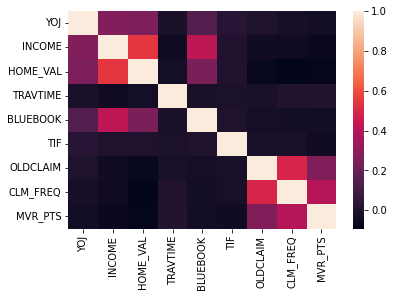

In [644]:
corr = train_data[["YOJ","INCOME","HOME_VAL","TRAVTIME","BLUEBOOK","TIF","OLDCLAIM","CLM_FREQ","MVR_PTS",]].corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

- I don't see super strong correlation. We have no strong linear correlation here.
- Let's check for no linear correlation.  

<AxesSubplot:>

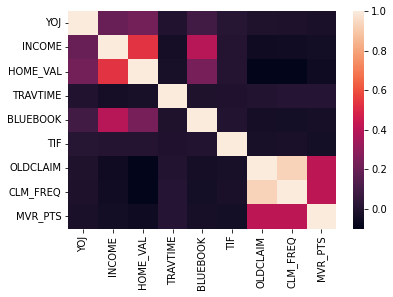

In [645]:
corr = train_data[["YOJ","INCOME","HOME_VAL","TRAVTIME","BLUEBOOK","TIF","OLDCLAIM","CLM_FREQ","MVR_PTS",]].corr(method = "spearman")

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

- We don't see stong correlation. 

In [646]:
train_data.TARGET_FLAG.value_counts()

0    6008
1    2153
Name: TARGET_FLAG, dtype: int64

Since we have unbalanced data set we will use a roc auc score as our performance metrics.

# Fit of the model 

# xg boost 

I have decieded to use an XBboost classifer because :
- It is easy to implement 
- Performs well 
- It is robust against overfitting

To train it i will use cross validation because :
- It leads to better results
- It is a good way to see if our model overfits 

To unsure we have representative folds (with both class represented) we use the  RepeatedStratifiedKFold function.

In [647]:
target = train_data["TARGET_FLAG"]
train_data = train_data.drop(["TARGET_FLAG"],axis =1)


In [620]:
# Some caracters in the name of the columns are not accepted by the librairy. We will remove them. 
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

train_data.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in train_data.columns.values]
unlabeled_data.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in unlabeled_data.columns.values]

param_grid = [
    {"n_estimators": [10,20,30],
    "scale_pos_weight": [1,2,4,10]},
]

model = XGBClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

search = GridSearchCV(estimator=model, param_grid=param_grid, scoring="roc_auc", cv=cv)
search.fit(train_data, target)


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     inter...
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid=[{'n_estimators': [10, 20, 30],
                          'scale_pos_weight': [1, 2, 4, 10]}],
             scoring='roc_auc')

In [621]:

print(search.best_score_)


0.8150394431358939


- We have a 'not to bad' score but there is room for imporvement (we are far from a roc auc of 1).
- We could have done a grid search to optimize other parameters but I had only 3 hours to do the test. So I have decided not to do it.
- Since we have an imbalanced data set I did so test with the scale_pos_weight parameters. But it did not help.

In [622]:
scores = cross_val_score(search.best_estimator_,train_data, target, scoring='roc_auc', cv=cv, n_jobs=-1)
print(scores)
print('Mean ROC AUC: %.3f' % np.mean(scores))

[0.84359401 0.80247649 0.83567697 0.80557211 0.80492203 0.81506017
 0.82073676 0.81773014 0.81274691 0.82126543 0.82994392 0.82844871
 0.78751693 0.79903262 0.80449251 0.82718725 0.83138181 0.81723484
 0.81324846 0.82181327 0.80738892 0.80719731 0.80503811 0.76802229
 0.80888442 0.81244438 0.8161359  0.8399644  0.82534722 0.82067901]
Mean ROC AUC: 0.815


- We have more or less the same values of ROC_AUC in our folders. It means we are not overfitting. 
- But we are using 41 features which can prevent our model from performing better. 
- I will try a PCA to reduce the dimension. 

In [623]:
from sklearn.metrics import confusion_matrix
test_sample = train_data.sample(frac=0.1)
test_answer = target.iloc[test_sample.index.values]

preidction = search.best_estimator_.predict(test_sample)

confusion_matrix(test_answer,preidction)


array([[528,  78],
       [ 37, 173]])

- We have better performances on class 0 than 1. 
- We can try to tune the scale_pos_weight to be have same performances on both class but I will focus on dimension reduction.

### PCA

2


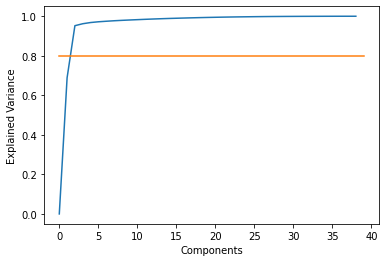

In [624]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plot

explained_var = []
flag = False
for nb_components in range(39):
    pca = PCA(n_components= nb_components)
    pca.fit(train_data)
    explained_var.append(sum(pca.explained_variance_ratio_))
    if sum(pca.explained_variance_ratio_) > 0.95 and not flag:
        flag = True
        print(nb_components)

    
plot.plot(explained_var)
plot.plot([0.8 for i in range(40)])
plot.ylabel('Explained Variance')
plot.xlabel('Components')
plot.show()


In [625]:
pca = PCA(n_components= 20)
pca.fit(train_data)

train_data_pca = pca.transform(train_data)
unlabeled_data_pca = pca.transform(unlabeled_data)

In [626]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

param_grid = [
    {"n_estimators": [10,20,30],
    "scale_pos_weight": [1,2,4,10]},
]

model = XGBClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

search_2 = GridSearchCV(estimator=model, param_grid=param_grid, scoring="roc_auc", cv=cv)
search_2.fit(train_data_pca, target)

scores = cross_val_score(search_2.best_estimator_,train_data_pca, target, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))
print(scores)

Mean ROC AUC: 0.782
[0.80742358 0.78504044 0.7722865  0.77682545 0.75721859 0.76353751
 0.78618968 0.79907905 0.7748804  0.78761188 0.78895899 0.80095964
 0.75591456 0.78859266 0.78267229 0.78609682 0.80158263 0.79552684
 0.76525463 0.77411651 0.791736   0.77865186 0.7538018  0.73149789
 0.76987192 0.76669117 0.79056224 0.81888713 0.80951389 0.79028549]


Doing sevrel test I have notice that the roc_auc score is an incresing function of the n_components in the PCA.Dimension reduction did not help.

I think to have better performances we can try to :
- Optimize the data preparation. (check for highly correlated data for example). 
- Try to fit another model. 
- Do a grid search on hyperparameters.
- Find a better solution for dimension reduction (one that handle none numeric data).

Our best model is the first grid search. We will use it to do our prediction.

# Prediction

In [648]:
unlabeled_data["TARGET_FLAG"] = search.best_estimator_.predict(unlabeled_data.values)


In [649]:
unlabeled_data["TARGET_FLAG"].value_counts()

0    1458
1     683
Name: TARGET_FLAG, dtype: int64

In [650]:
unlabeled_data.to_csv("predicted_values.csv")

In [651]:
unlabeled_data.shape

(2141, 42)